## Desafio

- Criar um modelo preditivo de regressão para prever o valor dos custos médicos individuais (encargos) cobrados pelo seguro de vida

## Sobre a base de dados

- A base de dados contém 1338 linhas com informações sobre a idade da pessoa, gênero, índice de massa corporal (IMC), número de filho, flag de verificação se a pessoa é fumante, região residencial do benefício e o valor do custo médico

## Dicionário de dados

- **Idade:** idade do beneficiário principal
- **Gênero:** gênero do contratante de seguros
- **IMC:** índice de massa corporal, fornecendo uma compreensão do corpo, peso relativamente altos ou baixos em relação à altura
- **Filhos:** número de filhos cobertos por seguro saúde / Número de dependentes
- **Fumante:** se a pessoa fuma (sim ou não)
- **Região:** a área residencial do beneficiário nos EUA (nordeste, sudeste, sudoeste ou noroeste)
- **Encargos:** custos médicos individuais cobrados pelo seguro de saúde

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [300]:
insurance_data_frame = pd.read_csv('insurance.csv')
insurance_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Observações:**
- Nenhum valor nulo nas colunas (todos os 1338 registros são válidos)
- Há três colunas categóricas (object) que podem ser tratadas. As colunas são 'sex', 'smoker', 'region'

In [301]:
insurance_data_frame.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### Transformação dos dados em valores númericos antes do inicio de qualquer outra tratativa

In [302]:
categorical_columns = ['sex', 'smoker', 'region']

one_hot_encoder = OneHotEncoder(sparse_output=False)

encoded_features = one_hot_encoder.fit_transform(insurance_data_frame[categorical_columns])
encoded_features_df = pd.DataFrame(
    encoded_features,
    columns=one_hot_encoder.get_feature_names_out(categorical_columns)
)

insurance_data_frame = pd.concat([insurance_data_frame.drop(columns=categorical_columns), encoded_features_df], axis=1)
insurance_data_frame.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Avaliação de dados outliers para análise de impacto de modelos preditivos

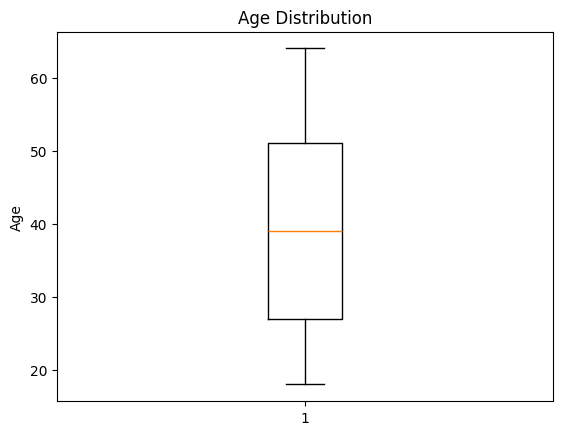

In [303]:
plt.boxplot(insurance_data_frame['age'])
plt.title('Age Distribution')
plt.ylabel('Age')
plt.show()

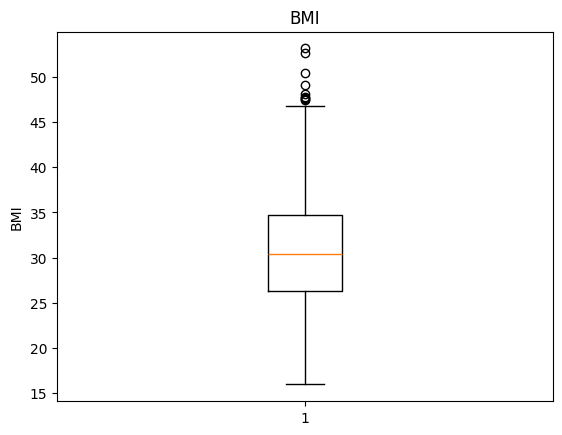

In [304]:
plt.boxplot(insurance_data_frame['bmi'])
plt.title('BMI')
plt.ylabel('BMI')
plt.show()

In [305]:
print(insurance_data_frame['bmi'].min())
print(insurance_data_frame['bmi'].max())

15.96
53.13


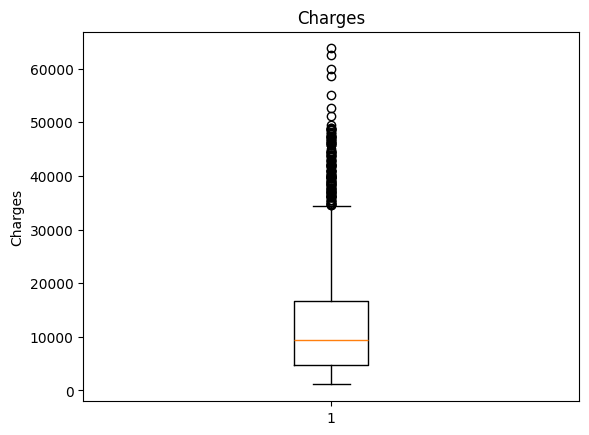

In [306]:
plt.boxplot(insurance_data_frame['charges'])
plt.title('Charges')
plt.ylabel('Charges')
plt.show()

In [307]:
print(insurance_data_frame['charges'].min())
print(insurance_data_frame['charges'].max())

1121.8739
63770.42801


### Analise de distribuição com o histograma

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'charges'}>,
        <Axes: title={'center': 'sex_female'}>,
        <Axes: title={'center': 'sex_male'}>],
       [<Axes: title={'center': 'smoker_no'}>,
        <Axes: title={'center': 'smoker_yes'}>,
        <Axes: title={'center': 'region_northeast'}>],
       [<Axes: title={'center': 'region_northwest'}>,
        <Axes: title={'center': 'region_southeast'}>,
        <Axes: title={'center': 'region_southwest'}>]], dtype=object)

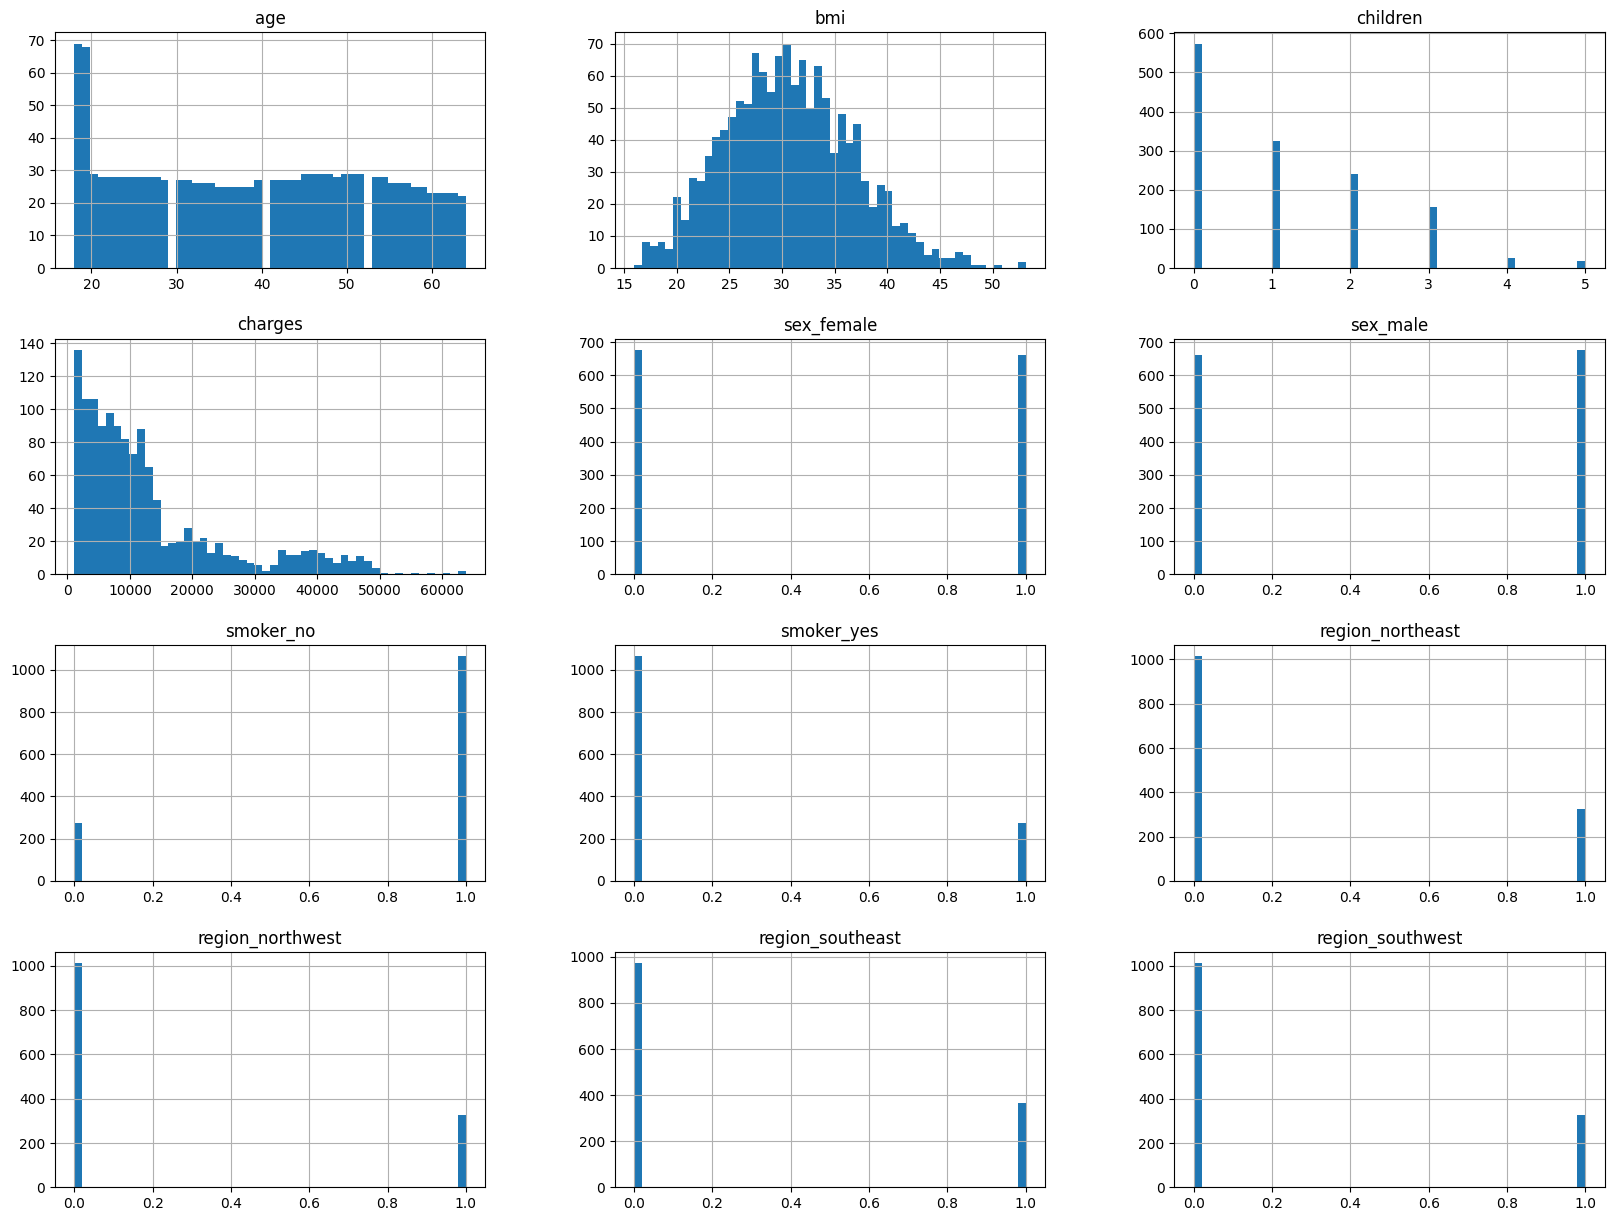

In [308]:
insurance_data_frame.hist(bins=50, figsize=(20, 15))

### Separação dos dados em treino e teste antes da normalização e padronização dos dados

In [309]:
x = insurance_data_frame.drop(columns=['charges'])
y = insurance_data_frame['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Aplicando o MinMaxScaler

In [310]:
minMaxScaler = MinMaxScaler()

minMaxScaler.fit(x_train)

x_train_min_max_scaled = minMaxScaler.transform(x_train)
x_test_min_max_scaled= minMaxScaler.transform(x_test)

x_train_min_max_scaled

array([[0.60869565, 0.10734463, 0.4       , ..., 1.        , 0.        ,
        0.        ],
       [0.63043478, 0.22491256, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.73913043, 0.23944041, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.86956522, 0.24791499, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.41304348, 0.85122411, 0.4       , ..., 0.        , 0.        ,
        1.        ],
       [0.80434783, 0.37503363, 0.        , ..., 0.        , 0.        ,
        1.        ]], shape=(1070, 11))

### Aplicando o StandardScaler

In [311]:
standardScaler = StandardScaler()

standardScaler.fit(x_train)

x_train_standard_scaled = standardScaler.transform(x_train)
x_test_standard_scaled  = standardScaler.transform(x_test)

x_train_standard_scaled

array([[ 0.47222651, -1.75652513,  0.73433626, ...,  1.78316783,
        -0.59966106, -0.5723141 ],
       [ 0.54331294, -1.03308239, -0.91119211, ..., -0.56079971,
        -0.59966106, -0.5723141 ],
       [ 0.8987451 , -0.94368672, -0.91119211, ..., -0.56079971,
         1.66760869, -0.5723141 ],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211, ..., -0.56079971,
        -0.59966106, -0.5723141 ],
       [-0.16755139,  2.82086429,  0.73433626, ..., -0.56079971,
        -0.59966106,  1.74729228],
       [ 1.1120044 , -0.10932713, -0.91119211, ..., -0.56079971,
        -0.59966106,  1.74729228]], shape=(1070, 11))

### Aplicando o RobustScaler

In [312]:
robustScaler = RobustScaler()

robustScaler.fit(x_train)

x_train_robust_scaled = robustScaler.transform(x_train)
x_test_robust_scaled = robustScaler.transform(x_test)
x_train_robust_scaled

array([[ 0.27083333, -1.23744912,  0.5       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.3125    , -0.71038746, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.52083333, -0.64525856, -0.5       , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.77083333, -0.6072667 , -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.10416667,  2.09739183,  0.5       , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.64583333, -0.03738881, -0.5       , ...,  0.        ,
         0.        ,  1.        ]], shape=(1070, 11))

# Avaliação do modelo

In [313]:
def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [314]:
def train_and_evaluate(scaler_name, x_train_scaled, x_test_scaled, y_train, y_test):
    print(f"Resultados para {scaler_name}:")
    
    # Criando o modelo de regressão linear
    linear_model = LinearRegression()
    linear_model.fit(x_train_scaled, y_train)
    
    # Previsões
    y_train_pred = linear_model.predict(x_train_scaled)
    y_test_pred = linear_model.predict(x_test_scaled)

    test_r2_score = r2_score(y_test, y_test_pred)
    train_r2_score = r2_score(y_train, y_train_pred)

    test_mean_squared_error = mean_squared_error(y_test, y_test_pred)
    train_mean_squared_error = mean_squared_error(y_train, y_train_pred)

    test_root_mean_squared_error = np.sqrt(test_mean_squared_error)
    train_root_mean_squared_error = np.sqrt(train_mean_squared_error)

    train_mape_result = calculate_mape(y_train, y_train_pred)
    test_mape_result = calculate_mape(y_test, y_test_pred)
    
    # Avaliação
    print("Treino:")
    print(f"  R²: {train_r2_score:.4f}")
    print(f"  MSE: {train_mean_squared_error:.4f}")
    print(f"  RMSE: {train_root_mean_squared_error:.4f}")
    print(f"  MAPE: {train_mape_result:.4f}%")
    
    print("Teste:")
    print(f"  R²: {test_r2_score:.4f}")
    print(f"  MSE: {test_mean_squared_error:.4f}")
    print(f"  RMSE: {test_root_mean_squared_error:.4f}")
    print(f"  MAPE: {test_mape_result:.4f}")
    

## Treino e resultado para avaliação da Regresão Linear Multipla

## Avaliação da Regressão Linear Multipla sem tratativa

In [315]:
train_and_evaluate("Sem tratativa", x_train, x_test, y_train, y_test)

Resultados para Sem tratativa:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


## Avaliação da Regressão Linear Multipla após aplicar o Standard Scaler

In [316]:
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)

x_train_standard_scaled = standard_scaler.transform(x_train)
x_test_standard_scaled = standard_scaler.transform(x_test)
train_and_evaluate("StandardScaler", x_train_standard_scaled, x_test_standard_scaled, y_train, y_test)

Resultados para StandardScaler:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


## Avaliação da Regressão Linear Multipla após aplicar o MinMaxScaler

In [317]:
train_and_evaluate("MinMaxScaler", x_train_min_max_scaled, x_test_min_max_scaled, y_train, y_test)

Resultados para MinMaxScaler:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


## Avaliação da Regressão Linear Multipla após aplicar o StandardScaler

In [318]:
train_and_evaluate("StandardScaler", x_train_standard_scaled, x_test_standard_scaled, y_train, y_test)

Resultados para StandardScaler:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


### Aplicando RobustScaler

In [319]:
train_and_evaluate("RobustScaler", x_train_robust_scaled, x_test_robust_scaled, y_train, y_test)

Resultados para RobustScaler:
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.8883


## Anotações da análise

**Por que os resultados são idênticos?**
- O LinearRegression do scikit-learn não é sensível à escala das variáveis se não há regularização (como Lasso ou Ridge).
- O LinearRegression() do scikit-learn resolve o sistema de equações diretamente via álgebra linear, então escalar os dados só altera os coeficientes, mas não o ajuste do modelo nem as previsões.
- Portanto, o resultado não muda com o escalonamento, desde que não haja termos de penalidade (como L1 ou L2).

**O que os seus resultados mostram sobre o modelo?**
- R² > 0.74 indica que o modelo consegue explicar cerca de 74% a 78% da variância dos dados, o que é razoável considerando apenas essa métrica.
- MSE e RMSE altos (~5796) indicam que há valores de charges bastante dispersos, o que pode estar ligado à presença de outliers (provável, dado o alto MAPE).
- MAPE elevado (42% a 46%) sugere que o modelo tem dificuldade com previsões absolutas em muitos casos, especialmente em valores menores (já que MAPE penaliza mais erros percentuais em valores baixos).

**Conclusões**
- O escalonamento não afeta a performance do LinearRegression sem regularização, pois o modelo é invariante à escala dos dados.
- O modelo mostra boa explicação de variância, mas tem erros absolutos relevantes, sugerindo que:
- Os dados podem ter outliers (verifique charges).
- Talvez o modelo esteja subajustado ou precise de transformações adicionais.
- Possíveis tentativas para melhorar o modelo:
    - Log-transformar charges se a distribuição for assimétrica.
    - Experimentar modelos mais robustos, como árvores (RandomForest, GradientBoosting).
    - Aplicar regularização (Ridge, Lasso) e aí sim comparar o impacto dos scalers.

**Próximos Passos:**
- Explorar Modelos Mais Complexos: Testar modelos não lineares, como árvores de decisão, random forest ou gradient boosting.
- Analisar Outliers: Verificar se outliers estão influenciando negativamente o modelo.
- Feature Engineering: Criar novas variáveis ou transformar as existentes para capturar melhor as relações nos dados.
- Avaliar Interações: Verificar se há interações entre variáveis que podem melhorar o desempenho do modelo.

## Visualizando a distribuição de 'charges'

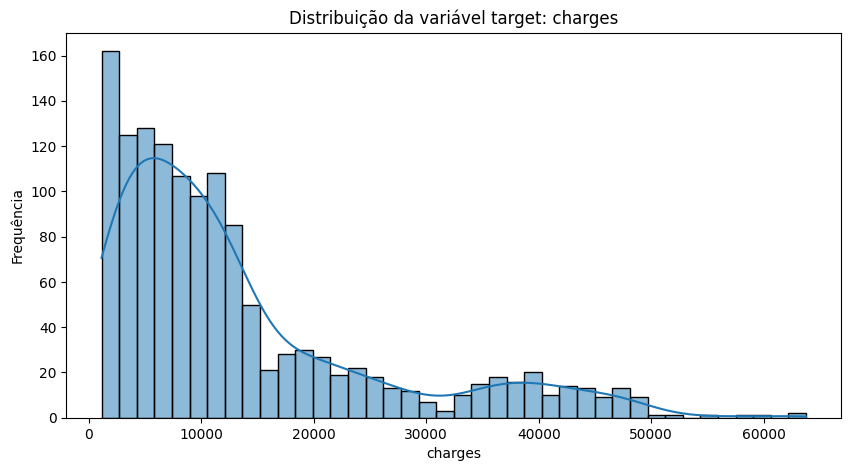

In [320]:
plt.figure(figsize=(10, 5))
sns.histplot(insurance_data_frame['charges'], kde=True, bins=40)
plt.title('Distribuição da variável target: charges')
plt.xlabel('charges')
plt.ylabel('Frequência')
plt.show()

# Aplicação da transformação logarítmica para validar a melhora do modelo LinearRegression

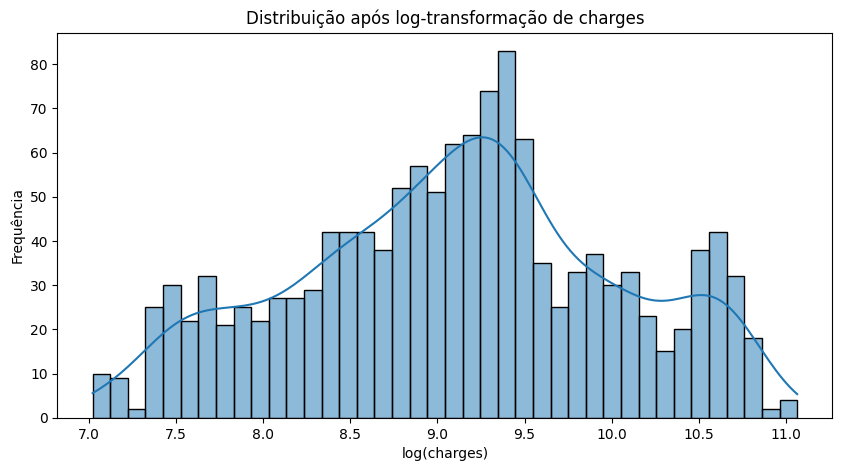

In [321]:
insurance_data_frame['log_charges'] = np.log(insurance_data_frame['charges'])

plt.figure(figsize=(10, 5))
sns.histplot(insurance_data_frame['log_charges'], kde=True, bins=40)
plt.title('Distribuição após log-transformação de charges')
plt.xlabel('log(charges)')
plt.ylabel('Frequência')
plt.show()

## Treinando o modelo com 'log_charges' como target

In [322]:
x = insurance_data_frame.drop(columns=['charges', 'log_charges'])
y = insurance_data_frame['log_charges']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
train_and_evaluate("transformação log para charges", x_train, x_test, y_train, y_test)

Resultados para transformação log para charges:
Treino:
  R²: 0.7572
  MSE: 0.2016
  RMSE: 0.4490
  MAPE: 3.0773%
Teste:
  R²: 0.8047
  MSE: 0.1756
  RMSE: 0.4190
  MAPE: 2.9975


# Explorando o modelo **Árvore de Decisão**

In [323]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Análise dos dados do arquivo insurance

In [324]:
insurance_data_frame = pd.read_csv('insurance.csv')
insurance_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [325]:
insurance_data_frame.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


## Pré-processamento do dataset usando one-hot encoder

In [326]:
categorical_columns = ['sex', 'smoker', 'region']

one_hot_encoder = OneHotEncoder(sparse_output=False)  # drop='first' para evitar multicolinearidade

encoded_features = one_hot_encoder.fit_transform(insurance_data_frame[categorical_columns])
encoded_features_df = pd.DataFrame(
    encoded_features,
    columns=one_hot_encoder.get_feature_names_out(categorical_columns)
)

insurance_data_frame = pd.concat([insurance_data_frame.drop(columns=categorical_columns), encoded_features_df], axis=1)
insurance_data_frame.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [327]:
insurance_data_frame.head(10)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5,31,25.740,0,3756.62160,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,46,33.440,1,8240.58960,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,37,27.740,3,7281.50560,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,37,29.830,2,6406.41070,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
9,60,25.840,0,28923.13692,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [328]:
print(insurance_data_frame['charges'].min())
print(insurance_data_frame['charges'].max())

1121.8739
63770.42801


## Separação dos dados de treino e teste

In [329]:
x = insurance_data_frame.drop(columns=['charges'])
y = insurance_data_frame['charges']

In [330]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Avaliação do modelo de Árvore de Decisão

### Sem tratamento de outliers

In [331]:
def avaliar_modelo(y_true, y_pred, conjunto):
    print(f'\nResultados para {conjunto}:')
    print(f'  R²: {r2_score(y_true, y_pred):.4f}')
    print(f'  MSE: {mean_squared_error(y_true, y_pred):.4f}')
    print(f'  RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}')
    print(f'  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.4f}%')

In [332]:
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(x_train, y_train)

y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

print('Avaliações')
avaliar_modelo(y_train, y_train_pred, "Treino")
avaliar_modelo(y_test, y_test_pred, "Teste")

Avaliações

Resultados para Treino:
  R²: 0.8779
  MSE: 17877779.8262
  RMSE: 4228.2124
  MAPE: 27.4184%

Resultados para Teste:
  R²: 0.8571
  MSE: 20957332.6058
  RMSE: 4577.9179
  MAPE: 30.8484%


## Avaliação dos atributos que contribuem para o target

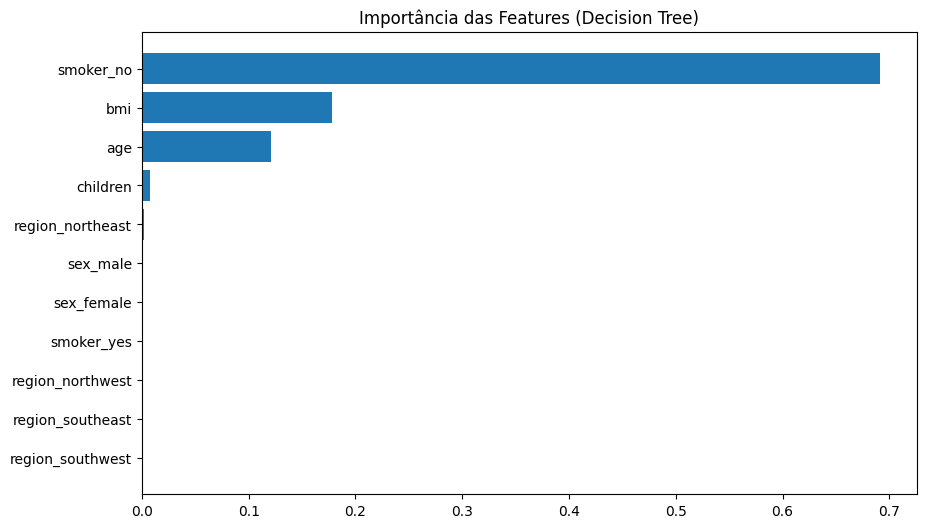

In [333]:
importances = tree.feature_importances_
features = x_train.columns
data_frame_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
data_frame_importances = data_frame_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(data_frame_importances['Feature'], data_frame_importances['Importance'])
plt.gca().invert_yaxis()
plt.title("Importância das Features (Decision Tree)")
plt.show()

In [334]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(x, y)

# Ver os scores
feature_scores = pd.DataFrame({
    'Feature': x.columns,
    'F-Score': selector.scores_,
    'p-Value': selector.pvalues_
}).sort_values(by='F-Score', ascending=False)

print(feature_scores)

             Feature      F-Score        p-Value
6         smoker_yes  2177.614868  8.271436e-283
5          smoker_no  2177.614868  8.271436e-283
0                age   131.174013   4.886693e-29
1                bmi    54.709308   2.459086e-13
9   region_southeast     7.352531   6.782699e-03
2           children     6.206037   1.285213e-02
3         sex_female     4.399702   3.613272e-02
4           sex_male     4.399702   3.613272e-02
10  region_southwest     2.499121   1.141466e-01
8   region_northwest     2.130837   1.445970e-01
7   region_northeast     0.053852   8.165264e-01


In [335]:
new_x = x.drop(columns=['region_southeast', 'children', 'sex_female', 'sex_male', 'region_southwest', 'region_northwest', 'region_northeast'])
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.3, random_state=42)
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(x_train, y_train)

y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

print('Avaliações')
avaliar_modelo(y_train, y_train_pred, "Treino")
avaliar_modelo(y_test, y_test_pred, "Teste")


Avaliações

Resultados para Treino:
  R²: 0.8721
  MSE: 18733336.0853
  RMSE: 4328.2024
  MAPE: 30.9130%

Resultados para Teste:
  R²: 0.8544
  MSE: 21348183.1451
  RMSE: 4620.4094
  MAPE: 34.5197%


## Resultados para Regressão Linear (sem tratativa de dados):
```plain text
Treino:
  R²: 0.7417
  MSE: 37277681.7020
  RMSE: 6105.5452
  MAPE: 42.2027%
Teste:
  R²: 0.7836
  MSE: 33596915.8514
  RMSE: 5796.2847
  MAPE: 46.888
```

## Resultados para Regressão Linear (tratando os outliers do meu target com transformação logarítmica)
```plain text
Treino:
  R²: 0.7572
  MSE: 0.2016
  RMSE: 0.4490
  MAPE: 3.0773%
Teste:
  R²: 0.8047
  MSE: 0.1756
  RMSE: 0.4190
  MAPE: 2.9975
```

## Resultado para Arvore de Decisão
```plain text
Avaliações

Resultados para Treino:
  R²: 0.8779
  MSE: 17877779.8262
  RMSE: 4228.2124
  MAPE: 27.4184%

Resultados para Teste:
  R²: 0.8571
  MSE: 20957332.6058
  RMSE: 4577.9179
  MAPE: 30.8484%

-- com menos campos
Resultados para Treino:
  R²: 0.8721
  MSE: 18733336.0853
  RMSE: 4328.2024
  MAPE: 30.9130%

Resultados para Teste:
  R²: 0.8544
  MSE: 21348183.1451
  RMSE: 4620.4094
  MAPE: 34.5197%
```